In [2]:
import matplotlib.pyplot as plt
import seaborn
from sklearn import datasets as sklearn_data
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib as mpl
import pandas as pd
import numpy as np

# Define Functions

0.001

(array([9.987e+03, 5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([   0.        ,  133.90984095,  267.81968189,  401.72952284,
         535.63936379,  669.54920474,  803.45904568,  937.36888663,
        1071.27872758, 1205.18856853, 1339.09840947]),
 <BarContainer object of 10 artists>)

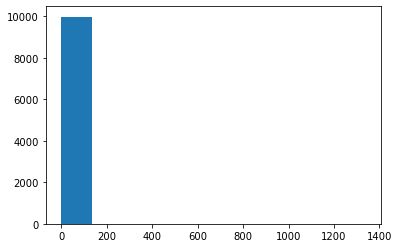

In [724]:
plt.hist(np.random.gamma(1e-3, 1e3, size = 10000))

In [420]:
import scipy
from scipy.stats import multivariate_normal as mvn
from scipy.stats import gamma

class BPCA(object):

    def __init__(self, a_alpha=1e-3, b_alpha=1e-3, a_tau=1, b_tau=1, beta=1e-3):
        # hyperparameters
        self.a_alpha = a_alpha # parameter of alpha's prior (a Gamma distribution)
        self.b_alpha = b_alpha # parameter of alpha's prior (a Gamma distribution)
        self.a_tau = a_tau     # parameter of tau's prior (a Gamma distribution)
        self.b_tau = b_tau     # parameter of tau's prior (a Gamma distribution)
        self.beta = beta
        # history of ELBOS
        self.elbos = None
        self.variations = None
        # history of log likelihoods
        self.loglikelihoods = None


    def update(self):
        """fixed-point update of the Bayesian PCA"""
        # inverse of the sigma^2
        self.tau = self.a_tau_tilde / self.b_tau_tilde
        # hyperparameters controlling the magnitudes of each column of the weight matrix
        self.alpha = self.a_alpha_tilde / self.b_alpha_tilde
        # covariance matrix of the latent variables
        self.cov_z = np.linalg.inv(np.eye(self.q) + self.tau *
                        (np.trace(self.cov_w) + np.dot(self.mean_w.T, self.mean_w)))
        # mean of the latent variable
        self.mean_z = self.tau * np.dot(np.dot(self.cov_z, self.mean_w.T), self.Xb - self.mean_mu)
        # covariance matrix of the mean observation
        self.cov_mu = np.eye(self.d) / (self.beta + self.b * self.tau)
        # mean of the mean observation
        self.mean_mu = self.tau * np.dot(self.cov_mu, np.sum(self.Xb-np.dot(self.mean_w,
                        self.mean_z), axis=1)).reshape(self.d, 1)
        # covariance matrix of each column of the weight matrix
        self.cov_w = np.linalg.inv(np.diag(self.alpha) + self.tau *
                        (self.b * self.cov_z + np.dot(self.mean_z, self.mean_z.T)))
        # mean of each column of the weight matrix
        self.mean_w = self.tau * np.dot(self.cov_w, np.dot(self.mean_z, (self.Xb-self.mean_mu).T)).T
        # estimation of the b in alpha's Gamma distribution
        self.b_alpha_tilde = self.b_alpha + 0.5 * (np.trace(self.cov_w) +
                        np.diag(np.dot(self.mean_w.T, self.mean_w)))
        # estimation of the b in tau's Gamma distribution
        self.b_tau_tilde = self.b_tau + 0.5 * np.trace(np.dot(self.Xb.T, self.Xb)) + \
                        0.5 * self.b*(np.trace(self.cov_mu)+np.dot(self.mean_mu.flatten(), self.mean_mu.flatten())) + \
                        0.5 * np.trace(np.dot(np.trace(self.cov_w)+np.dot(self.mean_w.T, self.mean_w),
                                        self.b*self.cov_z+np.dot(self.mean_z, self.mean_z.T))) + \
                        np.sum(np.dot(np.dot(self.mean_mu.flatten(), self.mean_w), self.mean_z)) + \
                        -np.trace(np.dot(self.Xb.T, np.dot(self.mean_w, self.mean_z))) + \
                        -np.sum(np.dot(self.Xb.T, self.mean_mu))
        

    def calculate_log_likelihood(self):
        """calculate the log likelihood of observing self.X"""
        w = self.mean_w
        c = np.eye(self.d)*self.tau + np.dot(w, w.T) 
        xc = self.X - self.X.mean(axis=1).reshape(-1,1)
        s = np.dot(xc, xc.T) / self.N
        self.s = s
        c_inv_s = scipy.linalg.lstsq(c, s)[0]
        loglikelihood = -0.5*self.N*(self.d*np.log(2*np.pi)+np.log(np.linalg.det(c))+np.trace(c_inv_s))
        return loglikelihood


    def calculate_ELBO(self):
        '''ELBO = E_q[-log(q(theta))+log(p(theta)+log(p(Y|theta,X)))]
                = -entropy + logprior + loglikelihood '''

        # random sample
        z = np.array([np.random.multivariate_normal(self.mean_z[:,i], self.cov_z) for i in range(self.b)]).T
        mu = np.random.multivariate_normal(self.mean_mu.flatten(), self.cov_mu)
        w = np.array([np.random.multivariate_normal(self.mean_w[i], self.cov_w) for i in range(self.d)])
        alpha = np.random.gamma(self.a_alpha_tilde, 1/self.b_alpha_tilde)
        tau = np.random.gamma(self.a_tau_tilde, 1/self.b_tau_tilde)

        # entropy
        # q(z)
        entropy = np.sum(np.array([mvn.logpdf(z[:,i], self.mean_z[:,i], self.cov_z) for i in range(self.b)]))

        # q(mu)
        entropy += mvn.logpdf(mu, self.mean_mu.flatten(), self.cov_mu)

        # q(W)
        entropy += np.sum(np.array([mvn.logpdf(w[i], self.mean_w[i], self.cov_w) for i in range(self.d)]))

        # q(alpha)
        entropy += np.sum(gamma.logpdf(alpha, self.a_alpha_tilde, scale=1/self.b_alpha_tilde))

        # q(tau)
        entropy += gamma.logpdf(tau, self.a_tau_tilde, scale=1/self.b_tau_tilde)

        # logprior
        # p(z), z ~ N(0, I)
        logprior = np.sum(np.array([mvn.logpdf(z[:,i], mean=np.zeros(self.q), cov=np.eye(self.q)) for i in range(self.b)]))

        # p(w|alpha), conditional gaussian
        logprior += np.sum(np.array([self.d/2*np.log(alpha[i]/(2*np.pi))-alpha[i]*np.sum(w[:,i]**2)/2 for i in range(self.q)]))

        # p(alpha), alpha[i] ~ Gamma(a, b)
        logprior += np.sum(gamma.logpdf(alpha, self.a_alpha, scale=1/self.b_alpha))

        # p(mu), mu ~ N(0, I/beta)
        logprior += mvn.logpdf(mu, mean=np.zeros(self.d), cov=np.eye(self.d)/self.beta)

        # p(tau), tau ~ Gamma(c, d)
        logprior += gamma.logpdf(tau, self.a_tau, scale=1/self.b_tau)

        # loglikelihood
        pred = np.dot(w, z) + mu.reshape(-1,1)
        loglikelihood = np.sum(np.array([mvn.logpdf(self.Xb[:,i], pred[:,i], np.eye(self.d)/tau) for i in range(self.b)]))

        return -entropy + logprior + loglikelihood


    def batch_idx(self, i):
        if self.b == self.N:
            return np.arange(self.N)
        idx1 = (i*self.b) % self.N
        idx2 = ((i+1)*self.b) % self.N
        if idx2 < idx1:
            idx1 -= self.N
        return np.arange(idx1, idx2)


    def fit(self, X=None, batch_size=128, iters=500, print_every=100, verbose=False, trace_elbo=False, trace_loglikelihood=False):
        """fit the Bayesian PCA model using fixed-point update"""
         # data, # of samples, dims
        self.X = X.T # don't need to transpose X when passing it
        self.d = self.X.shape[0]
        self.N = self.X.shape[1]
        self.q = self.d-1
        self.ed = []
        self.b = min(batch_size, self.N)

        # variational parameters
        self.mean_z = np.random.randn(self.q, self.b) # latent variable
        self.cov_z = np.eye(self.q)
        self.mean_mu = np.random.randn(self.d, 1)
        self.cov_mu = np.eye(self.d)
        self.mean_w = np.random.randn(self.d, self.q)
        self.cov_w = np.eye(self.q)
        self.a_alpha_tilde = self.a_alpha + self.d/2
        self.b_alpha_tilde = np.abs(np.random.randn(self.q))
        self.a_tau_tilde = self.a_tau + self.b * self.d / 2
        self.b_tau_tilde = np.abs(np.random.randn(1))

        # update
        order = np.arange(self.N)
        elbos = np.zeros(iters)
        loglikelihoods = np.zeros(iters)
        for i in range(iters):
            idx = order[self.batch_idx(i)]
            self.Xb = self.X[:,idx]
            self.update()
            if trace_elbo:
                elbos[i] = self.calculate_ELBO()
            if trace_loglikelihood:
                loglikelihoods[i] = self.calculate_log_likelihood()
            if verbose and i % print_every == 0:
                print('Iter %d, LL: %f, alpha: %s' % (i, loglikelihoods[i], str(self.alpha)))
        self.captured_dims()
        self.elbos = elbos if trace_elbo else None
        self.loglikelihoods = loglikelihoods if trace_loglikelihood else None


    def captured_dims(self):
        """return the number of captured dimensions"""
        sum_alpha = np.sum(1/self.alpha)
        self.ed = np.array([i for i, inv_alpha in enumerate(1/self.alpha) if inv_alpha < sum_alpha/self.q])


    def transform(self, X=None, full=True):
        """generate samples from the fitted model p(z|x)"""
        X = self.X if X is None else X.T
        if full:
            w = self.mean_w
            l = self.q
        else:
            w = self.mean_w[:,self.ed]
            l = len(self.ed)
        m = np.eye(l)*self.tau + np.dot(w.T, w)
        inv_m = np.linalg.inv(m)
        z = np.dot(np.dot(inv_m, w.T), X - self.mean_mu)
        return z.T # p(z|x)
        # return np.array([np.random.multivariate_normal(z[:,i], inv_m*self.tau) for i in range(X.shape[1])])

    def inverse_transform(self, z, full=True):
        """transform the latent variable into observations"""
        z = z.T
        if full:
            w = self.mean_w
        else:
            w = self.mean_w[:,self.ed]
        x = np.dot(w, z) + self.mean_mu
        return x.T
        # return np.array([np.random.multivariate_normal(x[:,i], np.eye(self.d)*self.tau) for i in range(z.shape[1])])


    def fit_transform(self, X=None, batch_size=128, iters=500, print_every=100, verbose=False, trace_elbo=False, trace_loglikelihood=False):
        self.fit(X, batch_size, iters, print_every, verbose, trace_elbo)
        return self.transform()


    def generate(self, size=1):
        """generate samples from the fitted model"""
        w = self.mean_w[:, self.ed]
        c = np.eye(self.d)*self.tau + np.dot(w, w.T)
        return np.array([np.random.multivariate_normal(self.mean_mu.flatten(), c) for i in range(size)])


    def get_weight_matrix(self):
        return self.mean_w


    def get_inv_variance(self):
        return self.alpha


    def get_effective_dims(self):
        return len(self.ed)


    def get_cov_mat(self):
        w = self.mean_w[:, self.ed]
        c = np.eye(self.d)*self.tau + np.dot(w, w.T) 
        return c


    def get_elbo(self):
        return self.elbos


    def get_loglikelihood(self):
        return self.loglikelihoods

In [421]:
def hinton(matrix=None, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    plt.show()

In [422]:
def plot_var(bpca, pca):
    
    BPCA_alpha = 1/bpca.get_inv_variance()
    
    plt.plot(sorted(BPCA_alpha, reverse=True)/np.sum(BPCA_alpha), label='scaled BPCA inverse alpha')
    plt.plot(pca.explained_variance_ratio_, label='PCA captured variance ratio')
    plt.xlabel('number of dimentions (0 indexed)')
    plt.ylabel('captured variance')
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    plt.title('Captured BPCA inverse variance vs. PCA explained variance')
    plt.legend()
    plt.show()

In [423]:
#helper function to visualize all weight matrices at one go
def hinton_all(bpca, pca):
    plt.subplot(1, 2,1)
    plt.title('PCA weight matrix')
    hinton(pca.components_)    
    plt.subplot(1,2,2)
    plt.title('BPCA weight matrix')
    hinton(bpca.get_weight_matrix().T)

# Experiments with ecological data

In [424]:
df = pd.read_csv("centered_scaled_adiantum.csv").drop(columns = "Unnamed: 0")
d = df.values

In [425]:
d

array([[-0.74159704,  0.62036352,  0.02365181, ..., -0.89340926,
         0.14199767,  0.07224737],
       [-0.77817631,  0.7689393 ,  0.09157495, ..., -0.86074957,
         0.14199767, -0.23558926],
       [ 0.13151185,  0.7689393 , -0.63859885, ..., -0.88034538,
         0.14199767, -0.85126252],
       ...,
       [-0.13099148,  0.5746479 ,  0.05761338, ..., -0.0246614 ,
         0.14199767,  5.30547008],
       [-0.18805742, -0.43109582, -0.2140792 , ..., -0.06385303,
        -0.78572046,  2.84277704],
       [-0.09675191, -0.19108879, -0.72350278, ...,  0.11250931,
         0.14199767,  1.30359389]])

In [426]:
# create BPCA class
bpca = BPCA()
# fit model
bpca.fit(d, iters = 5000, batch_size = 200, verbose=True, print_every=2500, trace_loglikelihood=True)

Iter 0, LL: -10078.119402, alpha: [ 20.54301803  14.57918505  25.81768645   6.14509802  24.29926287
  12.73198629  84.80783393  33.14057154  36.0295509   47.5499714
   7.5536587    9.01208733  10.81875243  18.53097593  15.60486098
  18.79416879  18.37459109 457.76265757  84.40594503  30.31447595
  20.42381097  94.01675555  19.59866379]
Iter 2500, LL: -3539.413491, alpha: [ 36.74605412 444.97783459 444.97783459   6.98214104 444.97783459
 444.97783459 444.97783459 444.97783459   9.73598385 444.97783459
 444.97783459  16.544432   444.97783459 444.97783459 444.97783459
 444.97783459  54.55195208 444.97783459 444.97783459  45.44014449
 444.97783459 444.97783459  75.70548367]


In [427]:
# pd.DataFrame(bpca.inverse_transform(bpca.transform())).to_csv("bpca-recon-adiantum.csv")

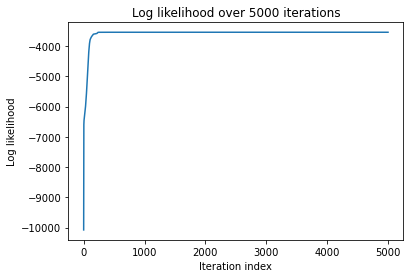

In [428]:
plt.plot(bpca.loglikelihoods)
plt.ylabel("Log likelihood")
plt.xlabel("Iteration index")
plt.title("Log likelihood over 5000 iterations")
plt.savefig("Log-likelihood-ada.png")

In [429]:
pca = PCA(n_components = bpca.get_effective_dims())
pca.fit(d)

PCA(n_components=18)

In [430]:
bpca.get_inv_variance()

array([ 36.74462681, 444.97651131, 444.97651131,   6.98822639,
       444.97651131, 444.97651131, 444.97651131, 444.97651131,
         9.7271174 , 444.97651131, 444.97651131,  16.54488044,
       444.97651131, 444.97651131, 444.97651131, 444.97651131,
        54.46616131, 444.97651131, 444.97651131,  45.49825028,
       444.97651131, 444.97651131,  75.71229691])

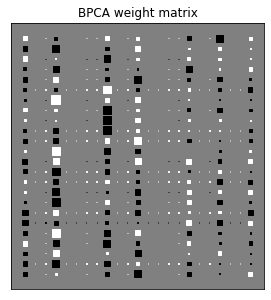

In [431]:
# 24 x 23 (each of 23 vectors of W has 24 values for each original feature.
# W is the subspace we project the latent variables on)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.title('BPCA weight matrix')
plt.savefig("hinton-bpca.png")
hinton(bpca.get_weight_matrix().T)

In [432]:
bpca.inverse_transform(bpca.transform())

array([[-0.07882296,  0.7831964 ,  0.00833841, ..., -0.47342577,
         0.85477601,  0.25816681],
       [-0.09492287,  0.60923763, -0.06242604, ..., -0.37341189,
         0.59034502,  0.15537531],
       [ 0.15990404,  0.30654736, -0.38660296, ..., -0.25240485,
         0.1481502 , -0.2154726 ],
       ...,
       [-0.0782247 ,  0.06228463, -0.06818416, ...,  0.22988098,
         0.34318484,  0.71658381],
       [-0.0606712 , -0.15043706,  0.06549262, ...,  0.20207437,
         0.02202337,  0.43482308],
       [-0.00728077, -0.34125999,  0.00180653, ...,  0.34311288,
        -0.20849228,  0.25822413]])

In [433]:
# W p x k
bpca.get_weight_matrix().shape

(24, 23)

Text(0.5, 1.0, 'inferred values of the $\\alpha$ hyper-parameter in BPCA')

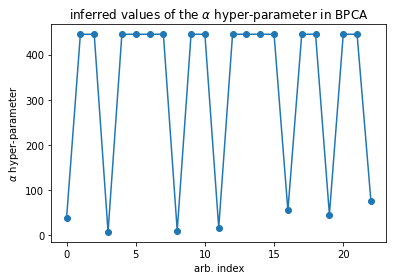

In [434]:
plt.plot(bpca.get_inv_variance(), 'o-')
plt.xlabel('arb. index')
plt.ylabel(r'$\alpha$ hyper-parameter')
plt.title(r'inferred values of the $\alpha$ hyper-parameter in BPCA')

In [435]:
# PCA with num of effective dimensions given in BPCA
x_tilde_pca = pca.inverse_transform(pca.transform(d))
x_tilde_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
x_tilde_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)
# generate data from bpca
gene = bpca.generate(98)

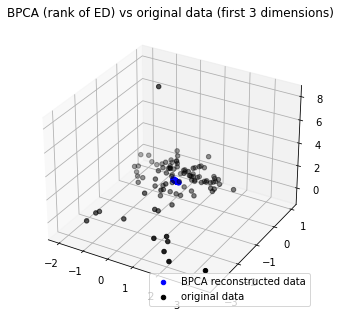

MSE (BPCA low rank): 94.31680759647509


In [436]:
# BPCA Reconstructed (low rank) vs original data

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_tilde_bpca_low[:, 0], x_tilde_bpca_low[:, 1], x_tilde_bpca_low[:, 2], c='b', label='BPCA reconstructed data')
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c='k', label='original data')
#ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', label='original data')
plt.title('BPCA (rank of ED) vs original data (first 3 dimensions)')
plt.legend(loc='lower right')
# plt.savefig("1low_bpca-orig.png")
plt.show()

print("MSE (BPCA low rank): " + str(np.mean(np.sum((d-x_tilde_bpca_low)**2, axis=0))))

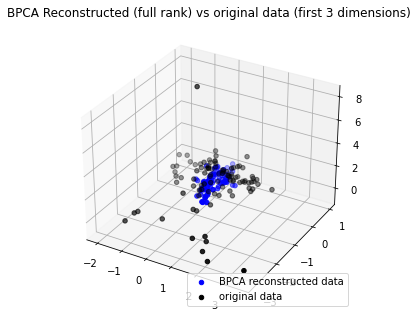

MSE (BPCA full rank): 54.36766133650402


In [437]:
# BPCA Reconstructed (full rank) vs original data

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_tilde_bpca_full[:, 0], x_tilde_bpca_full[:, 1], x_tilde_bpca_full[:, 2], c='b', label='BPCA reconstructed data')
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c='k', label='original data')
#ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', label='original data')
plt.title('BPCA Reconstructed (full rank) vs original data (first 3 dimensions)')
plt.legend(loc='lower right')
# plt.savefig("1full_bpca-orig.png")
plt.show()

print("MSE (BPCA full rank): " + str(np.mean(np.sum((d-x_tilde_bpca_full)**2, axis=0))))

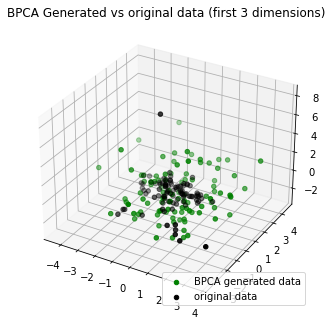

MSE (BPCA generated): 294.24891355073635


In [438]:
# BPCA GENERATED  vs original

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(gene[:, 0], gene[:, 1], gene[:, 2], c='g', label='BPCA generated data')
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c='k', label='original data')
#ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', label='original data')
plt.title('BPCA Generated vs original data (first 3 dimensions)')
plt.legend(loc='lower right')
# plt.savefig("1gen_bpca-orig.png")
plt.show()

print("MSE (BPCA generated): " + str(np.mean(np.sum((d-gene)**2, axis=0))))

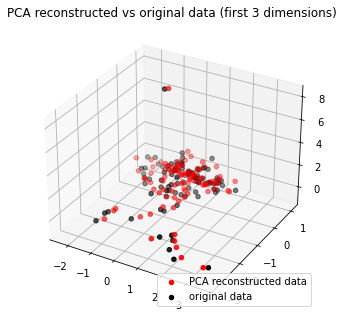

MSE (PCA recon): 3.4934857032057294


In [439]:
# conventional PCA vs original 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_tilde_pca[:, 0], x_tilde_pca[:, 1], x_tilde_pca[:, 2], c='r', label='PCA reconstructed data')
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c='k', label='original data')
#ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', label='original data')
plt.title('PCA reconstructed vs original data (first 3 dimensions)')
plt.legend(loc='lower right')
# plt.savefig("1pca-orig.png")
plt.show()

print("MSE (PCA recon): " + str(np.mean(np.sum((d-x_tilde_pca)**2, axis=0))))

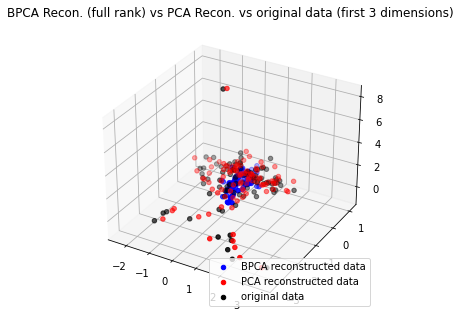

MSE (Recon PCA): 3.4934857032057294
MSE (Recon BPCA full rank): 54.36766133650402


In [440]:
# recon bpca (full), recon pca, original

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_tilde_bpca_full[:, 0], x_tilde_bpca_full[:, 1], x_tilde_bpca_full[:, 2], c='b', label='BPCA reconstructed data')
ax.scatter(x_tilde_pca[:, 0], x_tilde_pca[:, 1], x_tilde_pca[:, 2], c='r', label='PCA reconstructed data')
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c='k', label='original data')
#ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', label='original data')
plt.title('BPCA Recon. (full rank) vs PCA Recon. vs original data (first 3 dimensions)')
plt.legend(loc='lower right')
# plt.savefig("1full_bpca-pca-orig.png")
plt.show()

print("MSE (Recon PCA): " + str(np.mean(np.sum((d-x_tilde_pca)**2, axis=0))))
print("MSE (Recon BPCA full rank): " + str(np.mean(np.sum((d-x_tilde_bpca_full)**2, axis=0))))

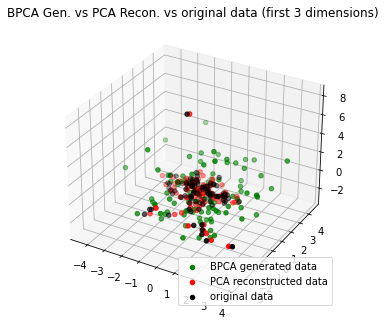

MSE (Recon PCA): 3.4934857032057294
MSE (Generated BPCA): 294.24891355073635


In [441]:
# generated bpca, recon pca, original

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(gene[:, 0], gene[:, 1], gene[:, 2], c='g', label='BPCA generated data')
ax.scatter(x_tilde_pca[:, 0], x_tilde_pca[:, 1], x_tilde_pca[:, 2], c='r', label='PCA reconstructed data')
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c='k', label='original data')
#ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='r', label='original data')
plt.title('BPCA Gen. vs PCA Recon. vs original data (first 3 dimensions)')
plt.legend(loc='lower right')
# plt.savefig("1gen_bpca-pca-orig.png")
plt.show()

print("MSE (Recon PCA): " + str(np.mean(np.sum((d-x_tilde_pca)**2, axis=0))))
print("MSE (Generated BPCA): " + str(np.mean(np.sum((d-gene)**2, axis=0))))

In [442]:
bpca_recon_mse_full = np.mean((d-x_tilde_bpca_full)**2, axis=0)
bpca_recon_mse_low = np.mean((d-x_tilde_bpca_low)**2, axis=0)
bpca_gene_mse = np.mean((d-gene)**2, axis=0)
pca_mse = np.mean((d-x_tilde_pca)**2, axis=0)

In [443]:
np.arange(0,24)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

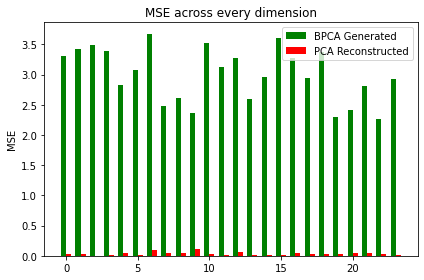

In [444]:
labels = np.arange(0,24)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bpca_gene_mse, width, label='BPCA Generated', color = 'g')
rects2 = ax.bar(x + width/2, pca_mse, width, label='PCA Reconstructed', color = 'r')

ax.set_ylabel('MSE')
ax.set_title('MSE across every dimension')
ax.legend()

fig.tight_layout()
# plt.savefig("1mse-gen-recon.png")
plt.show()

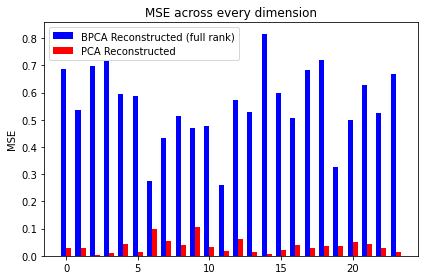

In [445]:
# full rank
labels = np.arange(0,24)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bpca_recon_mse_full, width, label='BPCA Reconstructed (full rank)', color = 'b')
rects2 = ax.bar(x + width/2, pca_mse, width, label='PCA Reconstructed', color = 'r')

ax.set_ylabel('MSE')
ax.set_title('MSE across every dimension')
ax.legend()

fig.tight_layout()
# plt.savefig("1mse-reconfull-recon.png")
plt.show()

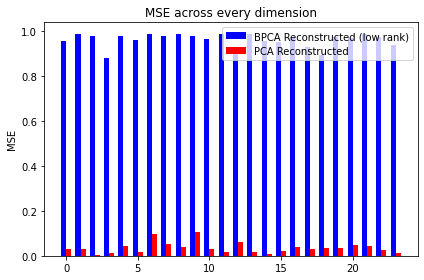

In [446]:
# reduced rank
labels = np.arange(0,24)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bpca_recon_mse_low, width, label='BPCA Reconstructed (low rank)', color = 'b')
rects2 = ax.bar(x + width/2, pca_mse, width, label='PCA Reconstructed', color = 'r')

ax.set_ylabel('MSE')
ax.set_title('MSE across every dimension')
ax.legend()

fig.tight_layout()
# plt.savefig("1mse-reconlow-recon.png")
plt.show()

In [447]:
mse_array = [np.mean(np.sum((d-x_tilde_pca)**2, axis=0)),
             np.mean(np.sum((d-x_tilde_bpca_full)**2, axis=0)),
             np.mean(np.sum((d-x_tilde_bpca_low)**2, axis=0)),
             np.mean(np.sum((d-gene)**2, axis=0))]

In [448]:
label = ['PCA', 'BPCA (full)', 'BPCA (ED)', 'BPCA (gen)']

Text(0.5, 1.0, 'MSE of each method')

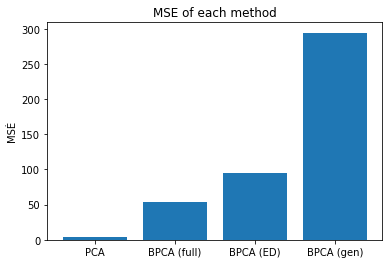

In [449]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method")
# plt.savefig("mse-all.png")

In [450]:
d.shape[0]

98

In [451]:
bpca.calculate_log_likelihood()

-3539.42494716106

In [452]:
print(f"(PCA) Log likelihood: {pca.score(d)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/d.shape[0]}")

(PCA) Log likelihood: -27.426580429834996
(BPCA) Log likelihood: -36.11658109348021


# MNIST

In [671]:
mnist = sklearn_data.load_digits()
Y = mnist.target
X = mnist.images
X = X.reshape(len(X),-1)

#fit a BPCA to this dataset
bpca = BPCA()
bpca.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

Iter 0, LL: -587461.485691, alpha: [  20.51139924  115.54626765   57.08089076   13.45595854 4705.78394315
   20.44738068   54.33461969   19.75737127   37.47728133   31.7030825
  118.83782674   31.08591828   31.81795208   64.53387412   68.94234208
  131.34292911   16.28988278 3924.92184495   21.47431076   54.74235255
 1251.80203113   15.48868836  141.32872097   14.92399522  337.17711742
   21.69992912   54.47413205   15.56092924  131.01885107   34.25086286
  388.12222566   27.53209658  154.63231936   28.5271417  1790.18017825
  270.09974754  146.6666971    79.55796507   23.51595926  477.64612531
   16.52021087   39.78452265  155.14114201   38.65864414   55.63678344
  115.00828677   55.9802372    67.27274695   59.59021077  119.60459578
   49.96208402   69.21917028   16.92279962   81.23658181   59.22940674
   33.07718455   44.23942369   16.51064884   29.92133922   22.70425059
   32.0668902    84.47069118   23.32058861]


In [686]:
bpca.ed

array([ 0,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 17, 18, 20, 22,
       23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61])

In [688]:
w0 = bpca.get_weight_matrix()[:,bpca.ed]

In [697]:
bpca.tau

11.610804118474194

In [703]:
i_tau0 = np.eye(bpca.d) * bpca.tau
i_tau0

array([[11.61080412,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 11.61080412,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 11.61080412, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 11.61080412,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        11.61080412,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 11.61080412]])

In [704]:
np.dot(w0, w0.T)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.87661031e-01, -2.62595416e-02, ...,
         6.45419785e-02, -2.26228923e-02, -3.03406254e-04],
       [ 0.00000000e+00, -2.62595416e-02,  8.27846556e-01, ...,
         7.42246804e-02,  3.50834521e-02,  6.51563545e-03],
       ...,
       [ 0.00000000e+00,  6.45419785e-02,  7.42246804e-02, ...,
         1.21670962e+00,  8.24515785e-02, -5.12390427e-03],
       [ 0.00000000e+00, -2.26228923e-02,  3.50834521e-02, ...,
         8.24515785e-02,  1.30441308e+00,  1.85636263e-02],
       [ 0.00000000e+00, -3.03406254e-04,  6.51563545e-03, ...,
        -5.12390427e-03,  1.85636263e-02,  3.38092944e-03]])

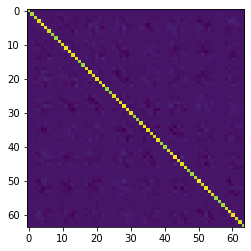

In [702]:
plt.imshow(i_tau0 + np.dot(w0, w0.T))

In [700]:
bpca.d

64

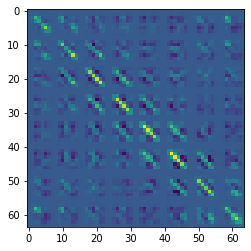

In [675]:
plt.imshow(pca.get_covariance())

In [674]:
#fit, transform, inverse transform the images
pca = PCA(n_components=bpca.get_effective_dims())

new_X_pca = pca.inverse_transform(pca.fit_transform(X))
new_X_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
new_X_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)

In [535]:
pca.inverse_transform(pca.fit_transform(X)).shape

(1797, 64)

In [536]:
gen = bpca.generate(1797)

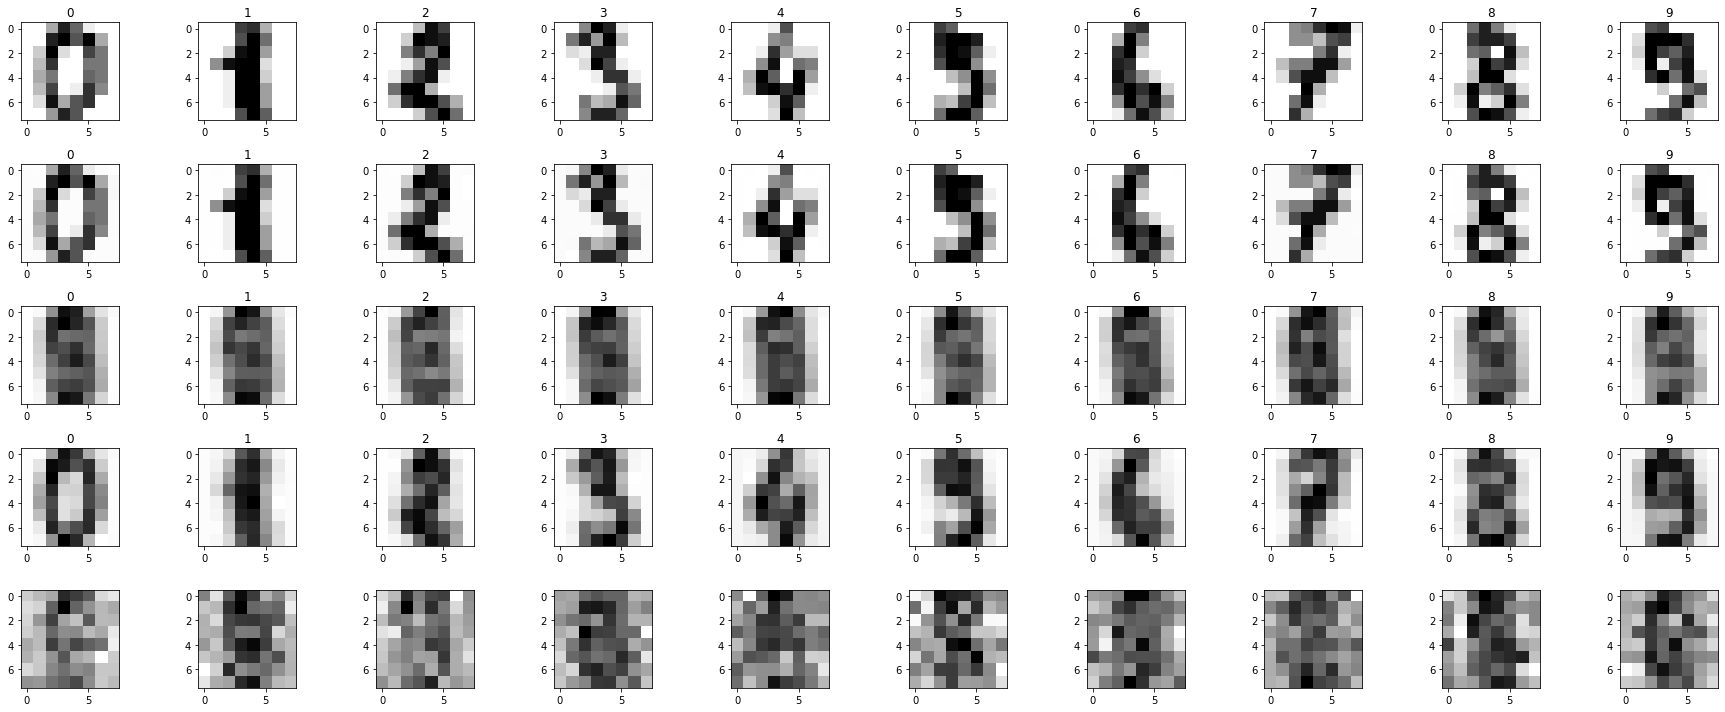

In [537]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-original-reconstructed-mnist.png")
plt.show()

In [538]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -121.48740622416165
(BPCA) Log likelihood: -167.91301836016652


In [539]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[15.27823077525531, 7799.040740193016, 30976.2853392223, 56673.90805766354]

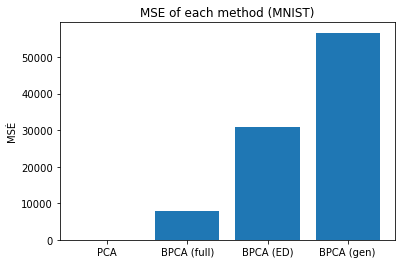

In [540]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
plt.savefig("original-mse-all-mnist.png")

## MNIST (update alpha)

In [541]:
#fit a BPCA to this dataset
bpca = BPCA(a_alpha=1, b_alpha=0.1)
bpca.fit(X, iters=5000, verbose=False, print_every=5000, trace_loglikelihood = True)

In [542]:
bpca.get_effective_dims()

46

In [547]:
#fit, transform, inverse transform the images
pca = PCA(n_components=bpca.get_effective_dims())

new_X_pca = pca.inverse_transform(pca.fit_transform(X))
new_X_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
new_X_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)
gen = bpca.generate(1797)

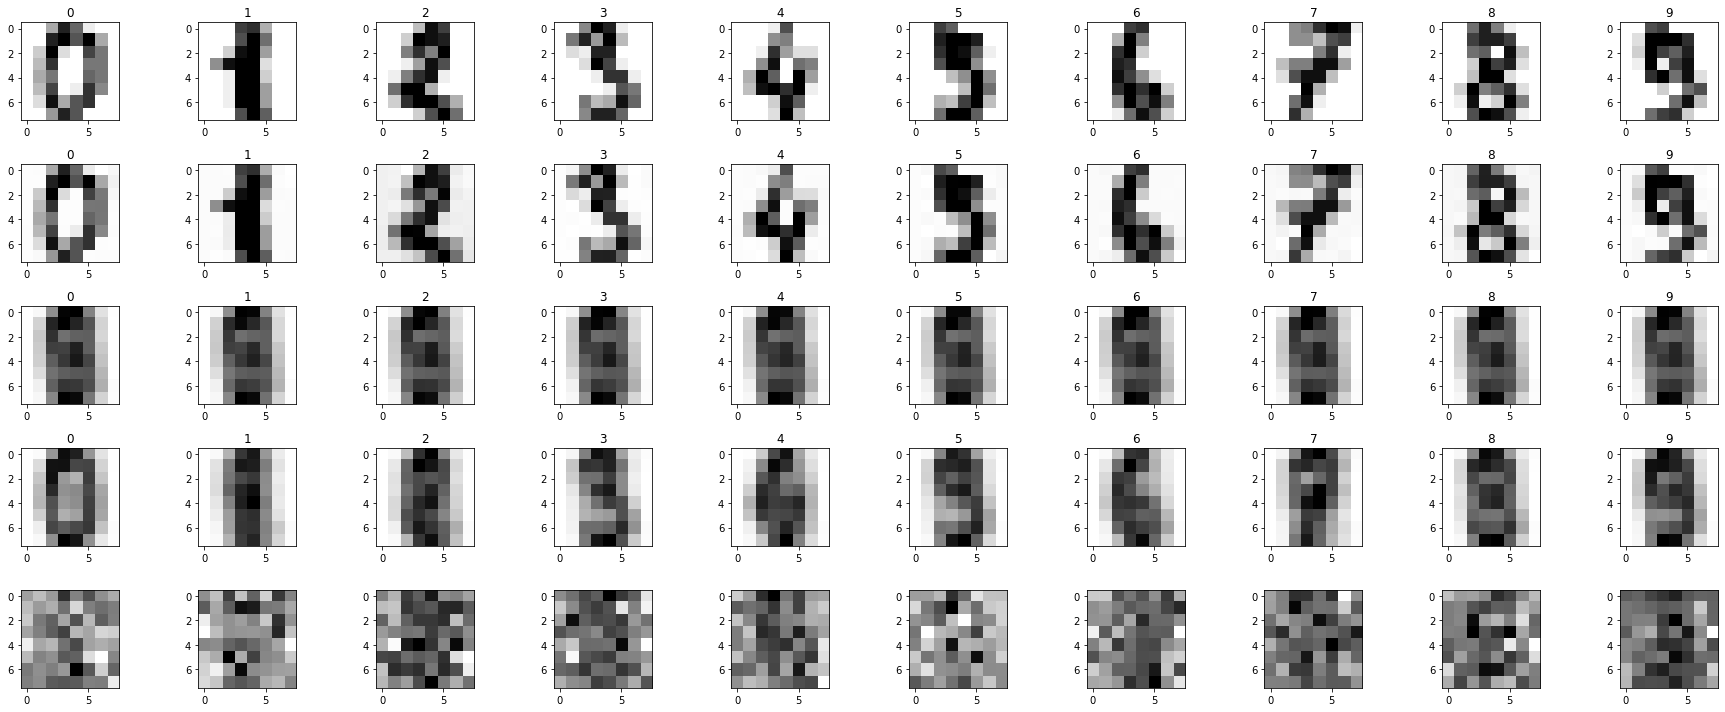

In [548]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model2-reconstructed-mnist.png")
plt.show()

In [549]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -130.7189292458251
(BPCA) Log likelihood: -194.51537737886278


In [550]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[106.37107030849275, 18141.88445642547, 33260.03407890402, 122558.11235608307]

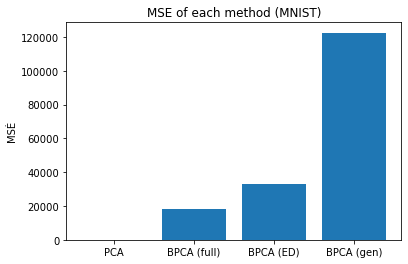

In [551]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
plt.savefig("model2-mse-all-mnist.png")

## MNIST (update tau)

In [552]:
#fit a BPCA to this dataset
bpca = BPCA(a_tau=1.25, b_tau=0.3)
bpca.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

Iter 0, LL: -533490.182525, alpha: [ 618.89076979   98.02373152   26.59960272   95.82087992   22.44596411
   52.91299738   27.62381558   39.52694265   27.01729506   67.62180334
   28.93372291  121.82894422   24.61805913   20.22061031   26.07625093
  482.88966458   34.47404865   77.16920592   25.58219824   20.87742005
   25.72456288   56.15071922   39.36545077  208.96961946   68.74110585
   21.37289917   49.89728405   17.7582759    13.78084836   39.08897728
   39.37852411  102.46294528   35.80208963   28.33172895   26.31145007
  191.81574226   19.49749078   39.20592213   74.15530238   55.82723312
   19.63371379   42.10757433   17.86781747  126.90895478   25.84232268
   83.10708717   96.14924034 1603.97240179   38.61727474   44.97475129
   99.44447114   71.24538951   48.02717812  133.87545926   29.78844897
   15.44170559  271.12575258   16.86406527   41.70229581   15.76841149
   59.01528862   51.14906728   25.47299581]


In [553]:
bpca.get_effective_dims()

50

In [556]:
#fit, transform, inverse transform the images
pca = PCA(n_components=bpca.get_effective_dims())

new_X_pca = pca.inverse_transform(pca.fit_transform(X))
new_X_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
new_X_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)
gen = bpca.generate(1797)

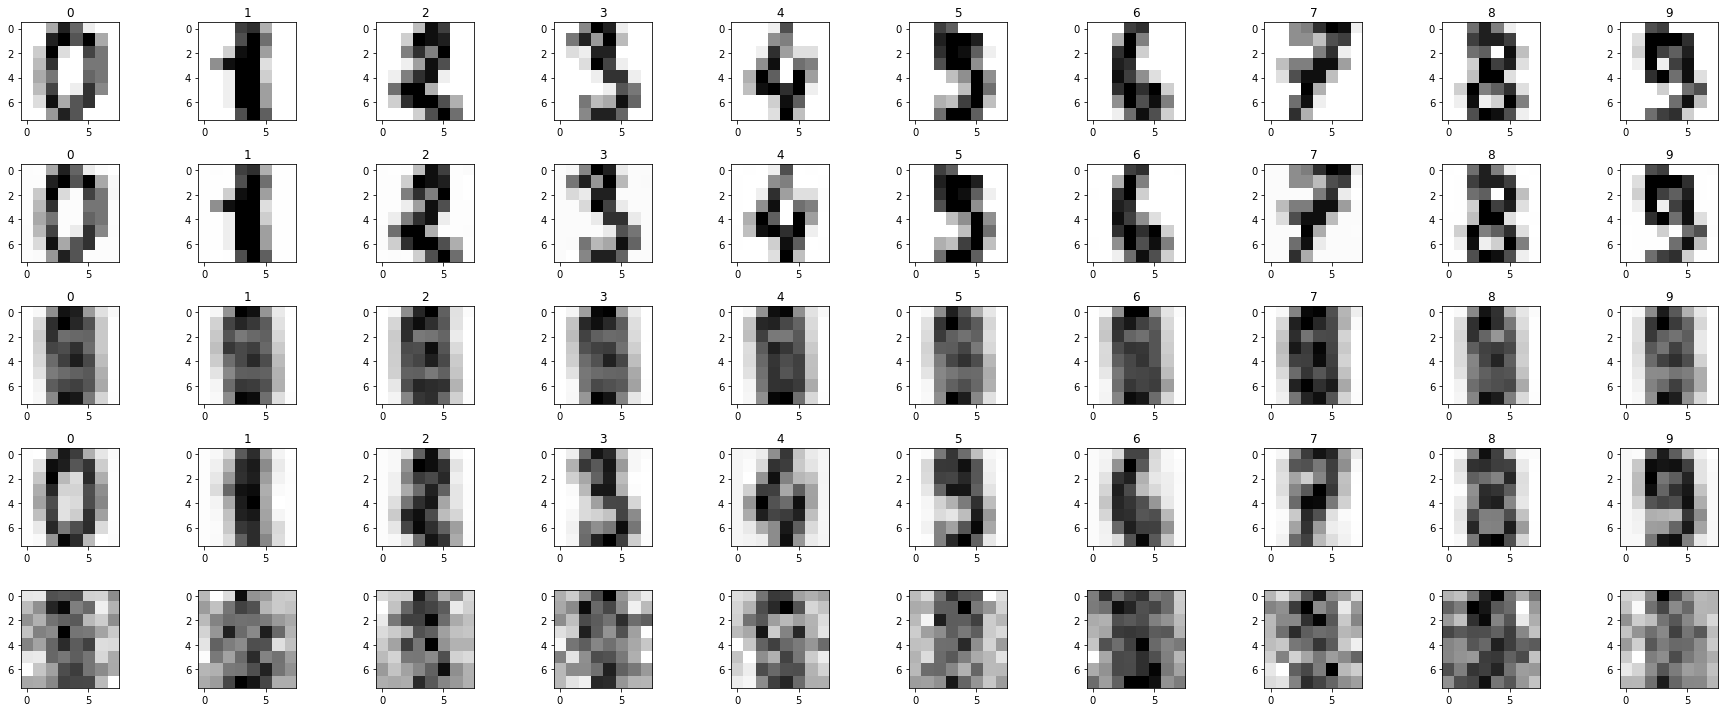

In [557]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model3-reconstructed-mnist.png")
plt.show()

In [559]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -121.48740622416167
(BPCA) Log likelihood: -168.07126192366326


In [560]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[15.278230775255311, 7874.68639945057, 30861.181486963116, 56752.24876633421]

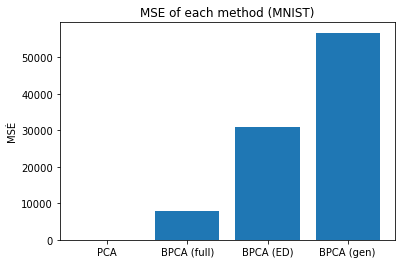

In [561]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
plt.savefig("mod3-mse-all-mnist.png")

## MNIST (update both)

In [568]:
#fit a BPCA to this dataset
bpca = BPCA(a_alpha=1, b_alpha=0.1, a_tau=1.25, b_tau=0.3)
bpca.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

Iter 0, LL: -630802.161424, alpha: [  25.62938233   10.64690576   35.9781233   395.73529503   13.26056591
   24.04266339   14.05746491   59.48474188  486.97381398   17.03837186
   61.1896164    62.01194891   22.84190076   17.7648368    21.53475588
   38.41715166   57.64070468   49.13179212  271.19407231 1158.48899278
   39.81400014   27.68121144   62.54805674  139.85109316   98.7584532
   42.63931169  687.26336665  100.90236195   18.24632747   38.99201552
  894.33377458   72.34521905   30.30208296   61.19934527   25.01521439
   44.33361399  283.01447391  216.83132403   25.85254425  404.58500147
  109.04938982   36.57332913   20.14971338  104.65222088   37.91119552
  198.16398765  360.81192014   62.54094901   88.99065931   48.99537971
  116.79546731   77.7668029   185.86551772   33.22281321   76.73165081
   48.06077245  199.84219498   36.60981459   62.29664289  279.81057142
  130.13677208   38.87890141   97.73441194]


In [569]:
bpca.get_effective_dims()

48

In [570]:
#fit, transform, inverse transform the images
pca = PCA(n_components=bpca.get_effective_dims())

new_X_pca = pca.inverse_transform(pca.fit_transform(X))
new_X_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
new_X_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)
gen = bpca.generate(1797)

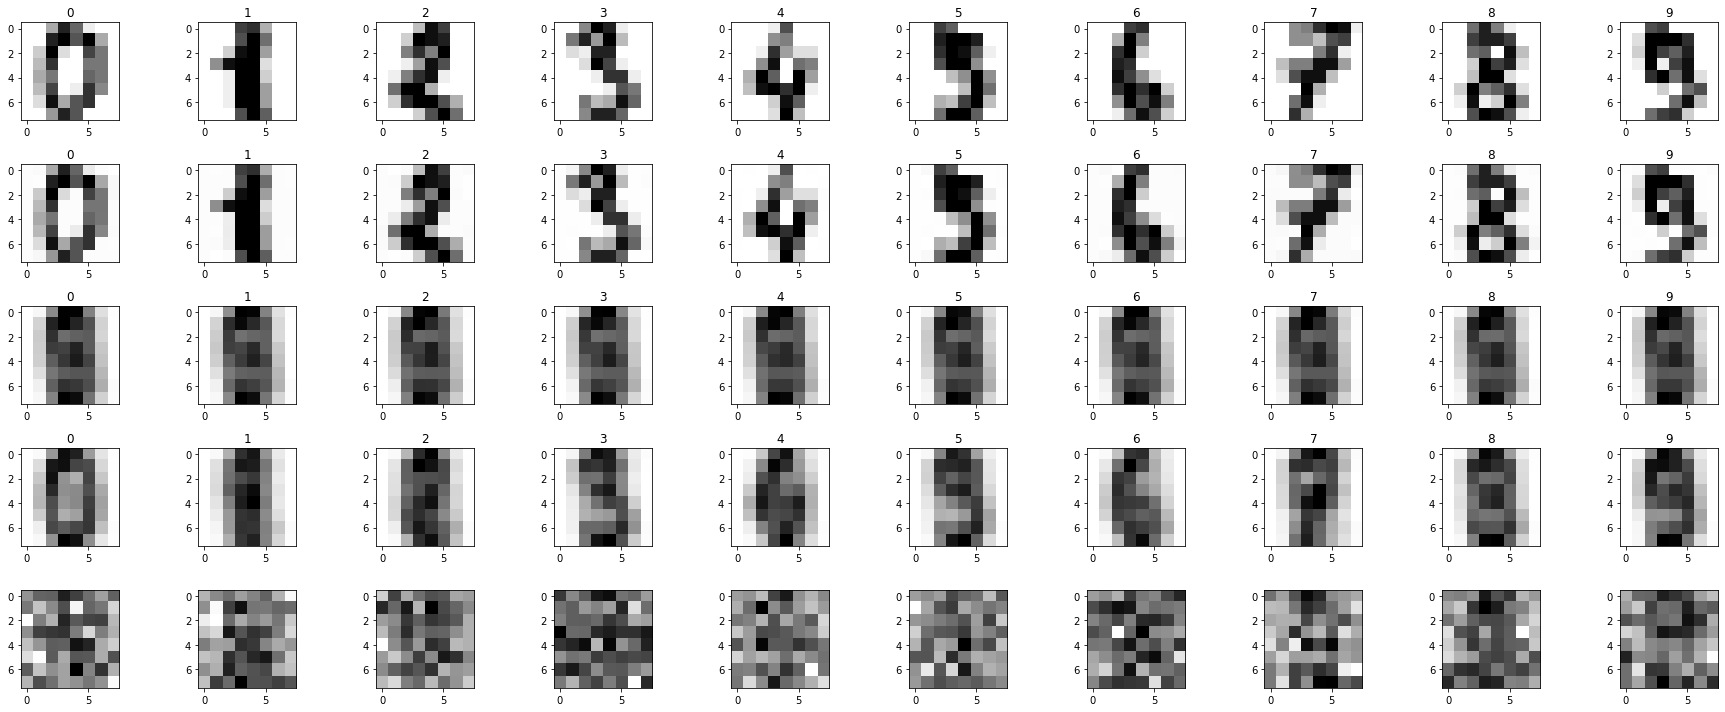

In [574]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model4-reconstructed-mnist.png")
plt.show()

In [572]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -126.84387117880794
(BPCA) Log likelihood: -195.71181493653555


In [573]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[47.71611822223844, 18515.742779034743, 33099.31067804405, 126959.27820058115]

Text(0.5, 1.0, 'MSE of each method (MNIST)')

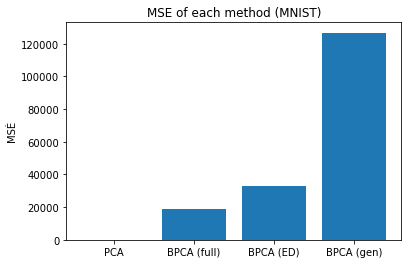

In [488]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
# plt.savefig("mse-all-mnist.png")

# MNIST (update large priors - model 5)

In [599]:
#fit a BPCA to this dataset
bpca = BPCA(a_alpha=1000, b_alpha=500, a_tau=1000, b_tau=500)
bpca.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

Iter 0, LL: -574257.813605, alpha: [ 5115.45479157  1593.23574839  1264.16207768  1019.7394916
   866.30364049  3400.19321062  2668.58325206  9223.00522899
   957.18684915  1719.98409426  3221.60987233  1075.994123
   491.82699183  1309.53047837 41094.93596845  3174.28883852
   629.75420008  1922.24408095   937.92867374  4263.03755244
 29645.08092919  1899.09220128  5628.09759019   816.65580555
   557.29203334  1108.32703489  1143.82892923   775.23318441
  4591.62310321   728.76075676  1324.1544932    693.36355232
   801.77983531  1337.33685975  1860.81813663   470.14864836
  4870.085089     964.59068771   469.67712014  1294.1161931
  1139.11047565  2284.83919754  2819.86192145   606.64435524
   652.34546074   671.20597569   480.70958535  1510.97987013
  7053.15736564  9955.40235783  2167.53035555   726.38586092
  1992.1022749   9817.74982179  1404.05804648  1194.90068293
 26251.83586265  1359.37757834  2582.39893101  1198.91950399
  1374.93965061   652.04645766  4579.98338612]


In [600]:
bpca.get_effective_dims()

34

In [601]:
#fit, transform, inverse transform the images
pca = PCA(n_components=bpca.get_effective_dims())

new_X_pca = pca.inverse_transform(pca.fit_transform(X))
new_X_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
new_X_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)
gen = bpca.generate(1797)

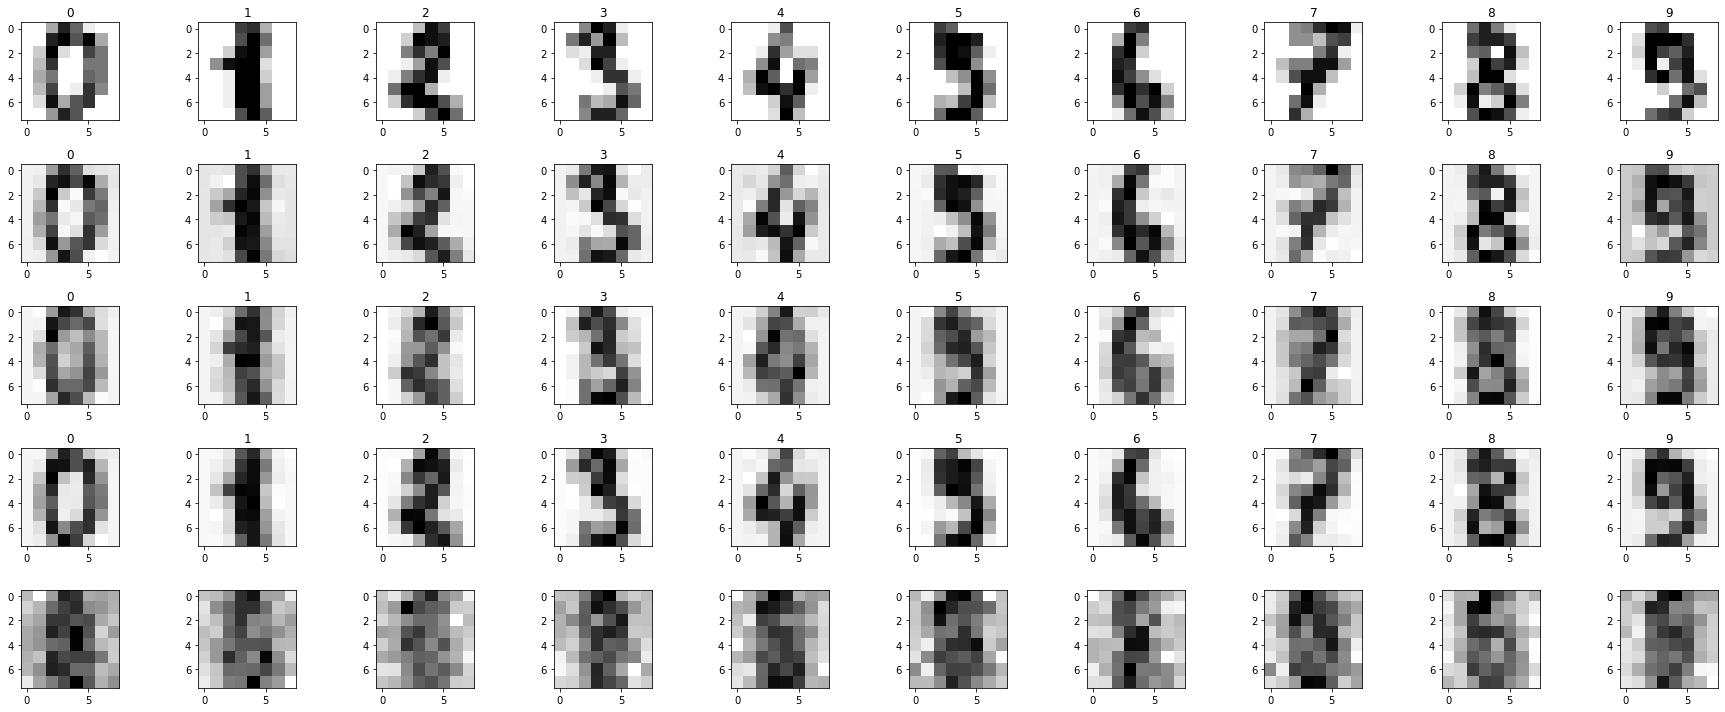

In [603]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model5-reconstructed-mnist.png")
plt.show()

In [604]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -141.01607539868778
(BPCA) Log likelihood: -155.26775704377272


In [605]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (Full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[910.8197933268211, 2465.7706863779167, 11336.08021965908, 43369.41381830875]

Text(0.5, 1.0, 'MSE of each method (MNIST)')

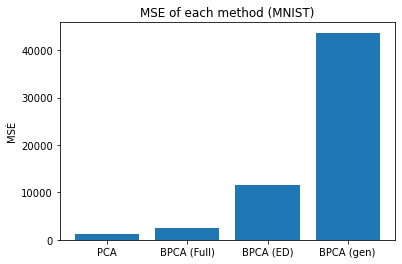

In [597]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
# plt.savefig("mse-all-mnist.png")

# Model 6

In [606]:
#fit a BPCA to this dataset
bpca = BPCA(a_alpha=1000, b_alpha=1000, a_tau=1000, b_tau=1000)
bpca.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

Iter 0, LL: -618576.772755, alpha: [  4721.42766976    692.46368019   8699.73759155   1036.18489637
   1063.50848048    898.93993623    860.19893238    997.21959523
    876.66606149   9083.63963056    865.78429079   4579.93035046
   5125.44270392    980.32778545  12476.78661874    867.23704078
   4404.5373445    1367.33689719    900.4788876    1367.37055376
   1619.83374819    697.4710092    1953.50424446   2813.07868622
    466.91487244   4151.83616819  14744.94262929    940.66417065
   4190.67814784   2619.82052372   1902.3683444     794.01099312
   1231.2166238   10892.31305701   4196.50619609   1507.09763765
   8522.88434755 194240.52107861   2486.44960135    683.53832241
 235749.87652393    939.29298505   3525.32284436    971.58976581
    375.56980832   1217.98544684    930.97672988   2638.70064485
   1428.5059291     722.28386712   1524.81619126   3390.17560226
   5488.91472303   1449.04418174  10298.71018292   1296.32093327
    997.17153906    851.99145532   4381.41463153   7686

In [607]:
bpca.get_effective_dims()

31

In [608]:
#fit, transform, inverse transform the images
pca = PCA(n_components=bpca.get_effective_dims())

new_X_pca = pca.inverse_transform(pca.fit_transform(X))
new_X_bpca_low = bpca.inverse_transform(bpca.transform(full = False), full = False)
new_X_bpca_full = bpca.inverse_transform(bpca.transform(full = True), full = True)
gen = bpca.generate(1797)

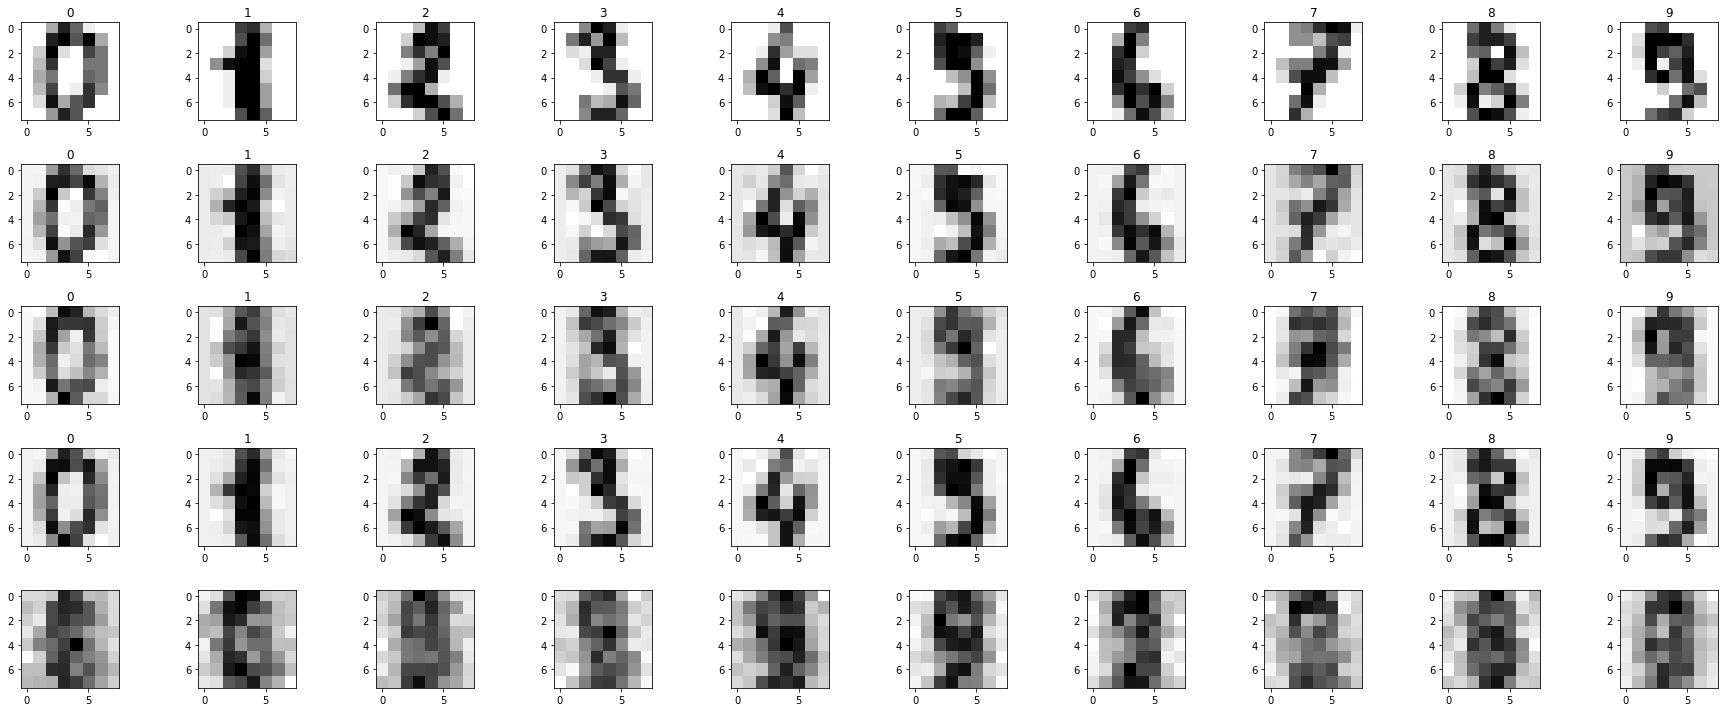

In [616]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model6-reconstructed-mnist.png")
plt.show()

In [612]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -142.73283196567633
(BPCA) Log likelihood: -150.1826878678869


In [614]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (Full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[1254.3293778235025, 1427.721351420206, 9814.8215484424, 40598.61588287662]

Text(0.5, 1.0, 'MSE of each method (MNIST)')

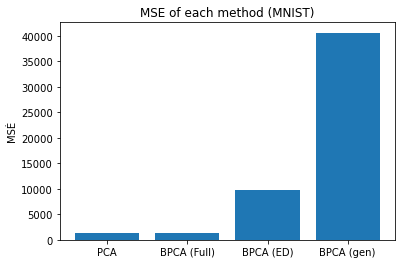

In [615]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
# plt.savefig("mse-all-mnist.png")

# Model 7

In [725]:
#fit a BPCA to this dataset
bpca7 = BPCA(a_alpha=1e5, b_alpha=1e5, a_tau=1e5, b_tau=1e5)
bpca7.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

/Users/phil/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Iter 0, LL: -inf, alpha: [  52847.94244714   85241.50902435  245214.81819812  186972.72238654
  787678.19518832  259916.58355866  125961.33362347   74036.13409525
   98181.6130253    90014.49177189  155230.02451302 2384826.44677957
   60165.48044122  136211.27582755  555659.85930005  105993.17372942
  164352.92013222  115802.94570492  148118.05952709   52440.73406916
  152398.08995204   91298.47942423   71183.90331156  297095.5284819
   97701.03748419  146808.99648107   62281.80563463  380753.75866935
  147847.77090908  188445.91252365  252871.48923648  132128.24907036
  117003.64908796  281237.48641808  170260.34461873  128016.89818991
  140285.19309463   85001.51789931  162953.81837168  456133.65998051
   59298.18674849   60539.1966677   240850.16411817  347441.0189978
  191342.09352208  209351.98187087   64942.53164863  652332.25001839
  361148.23129731  577037.26229164   83634.52697824   77715.83539926
  570577.90012862  748378.09441729   65298.66476918  235591.66383583
  638183.26

In [726]:
bpca7.get_effective_dims()

0

In [663]:
#fit, transform, inverse transform the images
pca7 = PCA(n_components=bpca7.get_effective_dims())

new_X_pca7 = pca7.inverse_transform(pca7.fit_transform(X))
new_X_bpca_low7 = bpca7.inverse_transform(bpca7.transform(full = False), full = False)
new_X_bpca_full7 = bpca7.inverse_transform(bpca7.transform(full = True), full = True)
gen7 = bpca7.generate(1797)

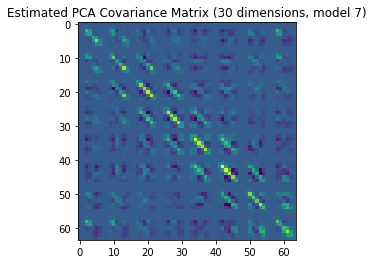

In [679]:
plt.title("Estimated PCA Covariance Matrix (30 dimensions, model 7)")
plt.imshow(pca7.get_covariance())

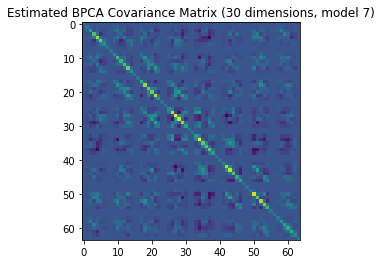

In [680]:
plt.title("Estimated BPCA Covariance Matrix (30 dimensions, model 7)")
plt.imshow(bpca7.get_cov_mat())

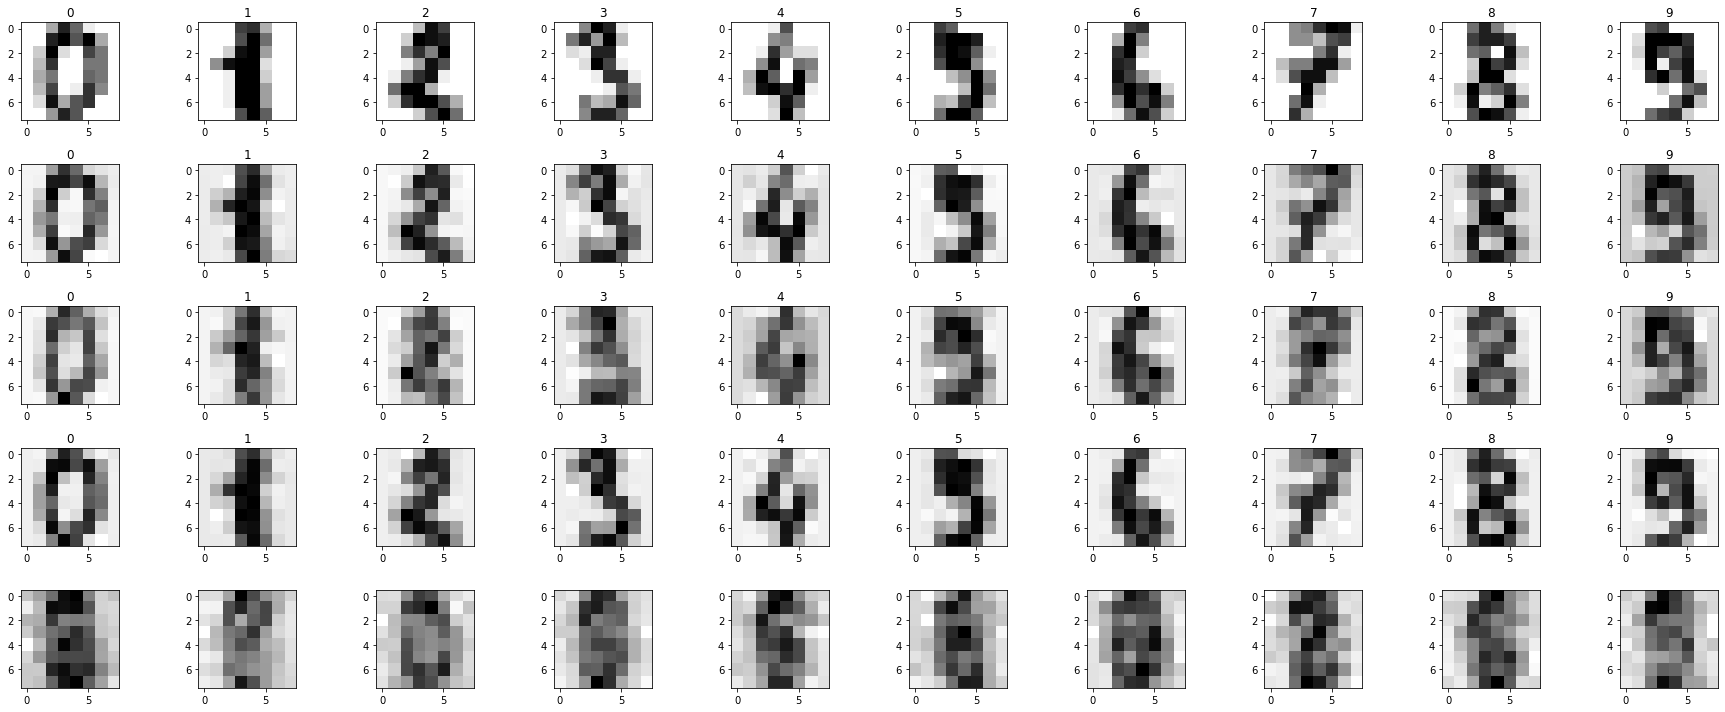

In [624]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model7-reconstructed-mnist.png")
plt.show()

In [625]:
print("\n")
print(f"(PCA) Log likelihood: {pca.score(X)}")
print(f"(BPCA) Log likelihood: {bpca.calculate_log_likelihood()/X.shape[0]}")



(PCA) Log likelihood: -143.2537605436893
(BPCA) Log likelihood: -151.71037911636336


In [626]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (Full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[1380.3718658912417, 1272.0544591386902, 9831.998313790966, 38924.306459983825]

Text(0.5, 1.0, 'MSE of each method (MNIST)')

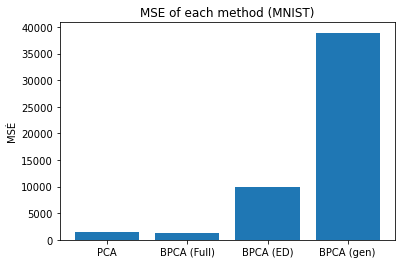

In [627]:
plt.bar(label, mse_array)
plt.ylabel("MSĖ")
plt.title("MSE of each method (MNIST)")
# plt.savefig("mse-all-mnist.png")

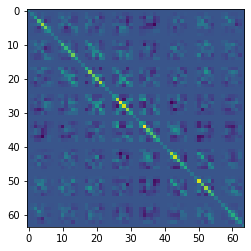

In [652]:
plt.imshow(bpca7.get_cov_mat())

Text(0.5, 1.0, 'inferred values of the $\\alpha$ hyper-parameter in BPCA')

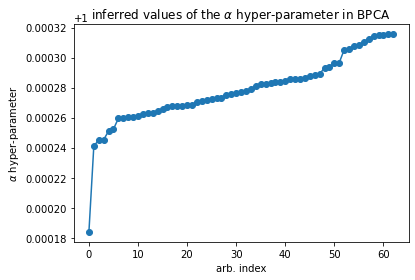

In [635]:
plt.plot(sorted(bpca.get_inv_variance()), 'o-')
plt.xlabel('arb. index')
plt.ylabel(r'$\alpha$ hyper-parameter')
plt.title(r'inferred values of the $\alpha$ hyper-parameter in BPCA')

# Model 8

In [729]:
#fit a BPCA to this dataset
bpca7 = BPCA(a_tau=1e5, b_tau=1e5)
bpca7.fit(X, iters=5000, verbose=True, print_every=5000, trace_loglikelihood = True)

Iter 0, LL: -inf, alpha: [  64.49869501   59.34612137 1072.12287651   19.77812892  116.45745539
   49.06592772   84.31607483   56.52287427  138.82475967   92.3473576
   19.99162289 2331.57693801   57.97451175  178.82590813   52.92761037
   17.01275932   56.56058191  214.1440339    70.41586682   52.38261205
  255.72624619   33.67551039  114.58406959  218.6006385   110.57478976
  123.37841597   41.61569905  164.56166881   34.46600927   33.568254
   27.30954298   36.47908194   25.81744103   56.83417057   52.78477164
   43.74408428  359.04585795   25.20314305   28.48188709   51.35110137
   94.38461586 1569.33642705   33.09670458  121.14817299  310.87099041
   53.93182103   48.22861749   52.00858636   52.30690226  179.64548535
   25.88446418   47.08806849   17.96145947  629.761035     38.65706922
   37.77525958   47.3982377    62.9207217    58.56482935   34.12051735
   29.09010034   75.46771464   80.3640363 ]


In [730]:
bpca7.get_effective_dims()

49

In [731]:
#fit, transform, inverse transform the images
pca7 = PCA(n_components=bpca7.get_effective_dims())

new_X_pca7 = pca7.inverse_transform(pca7.fit_transform(X))
new_X_bpca_low7 = bpca7.inverse_transform(bpca7.transform(full = False), full = False)
new_X_bpca_full7 = bpca7.inverse_transform(bpca7.transform(full = True), full = True)
gen7 = bpca7.generate(1797)

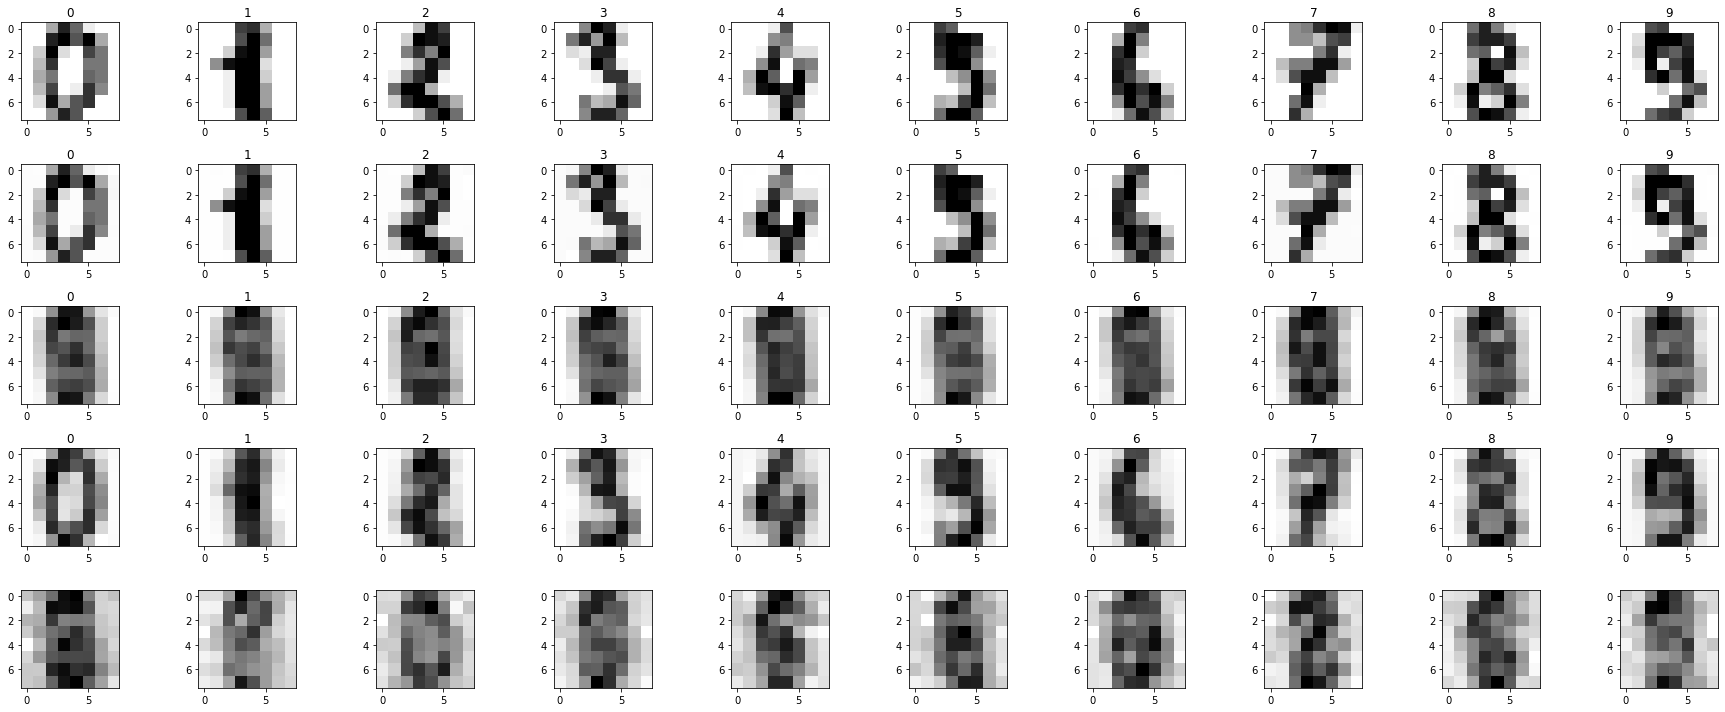

In [732]:
num_idx = [0,1,2,3,4,5,6,7,8,9]
fig = plt.figure(figsize=(25, 10))
for i in range(10):
    sel_index = num_idx[i]
    plt.subplot(5,10,i+1, title=str(mnist.target[sel_index]))
    plt.imshow(mnist.images[sel_index], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+11, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_pca[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+21, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_low[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+31, title=str(mnist.target[sel_index]))
    plt.imshow(new_X_bpca_full[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.subplot(5,10,i+41)
    plt.imshow(gen[sel_index].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.savefig("updated-model7-reconstructed-mnist.png")
plt.show()

In [733]:
mse_array = [np.mean(np.sum((X-new_X_pca)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_full)**2, axis=0)),
             np.mean(np.sum((X-new_X_bpca_low)**2, axis=0)),
             np.mean(np.sum((X-gen)**2, axis=0))]

label = ['PCA', 'BPCA (Full)', 'BPCA (ED)', 'BPCA (gen)']
mse_array

[15.278230775255311,
 7839.9677922936235,
 30938.902846147997,
 38924.306459983825]